In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
%matplotlib inline
sns.set(style="whitegrid")

# Diabetes Prediction Ananlysis

In [20]:
df = pd.read_csv('diabetes.csv')
print(f"Shape: {df.shape}")
df.head()

Shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


# Exploratory Data Analysis

In [21]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [22]:
df.isnull().sum()  # No explicit NaNs, but zeros are issues

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

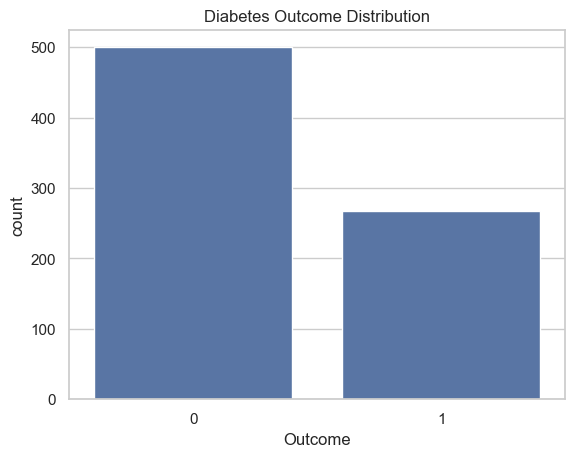

Outcome
0    0.651042
1    0.348958
Name: proportion, dtype: float64


In [23]:
sns.countplot(x='Outcome', data=df)
plt.title('Diabetes Outcome Distribution')
plt.show()
print(df['Outcome'].value_counts(normalize=True))

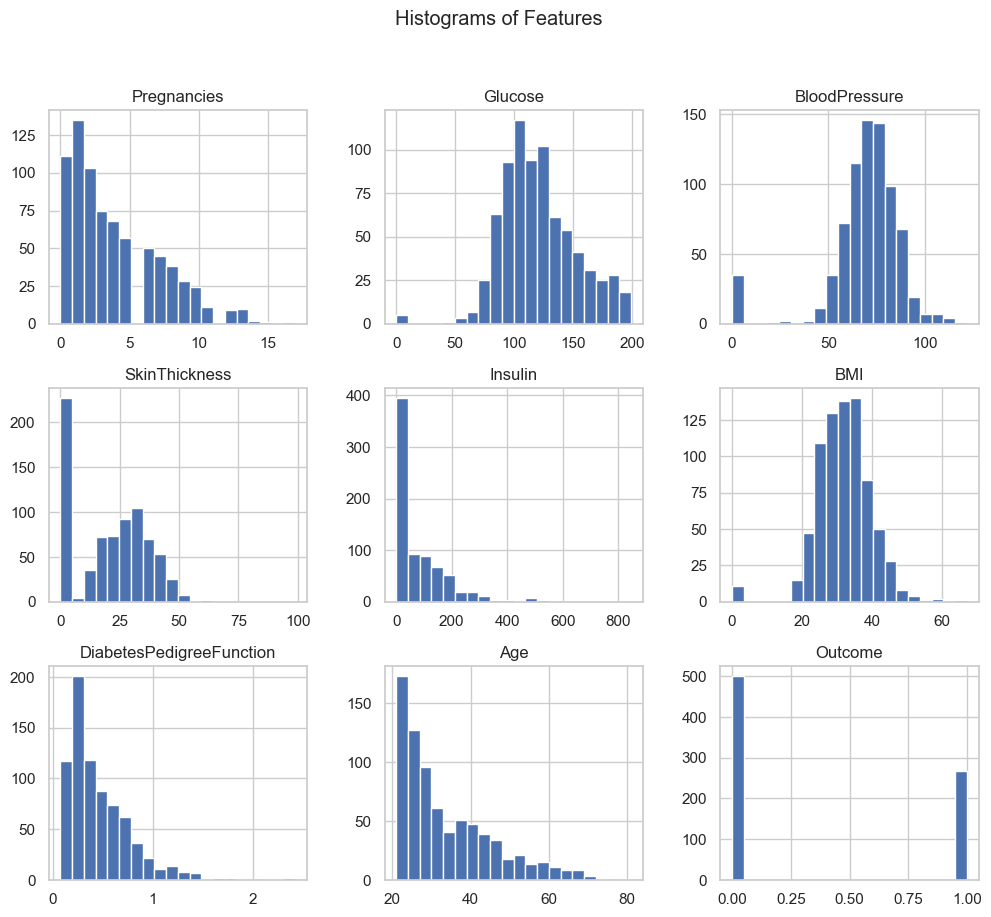

In [24]:
df.hist(figsize=(12, 10), bins=20)
plt.suptitle('Histograms of Features')
plt.show()

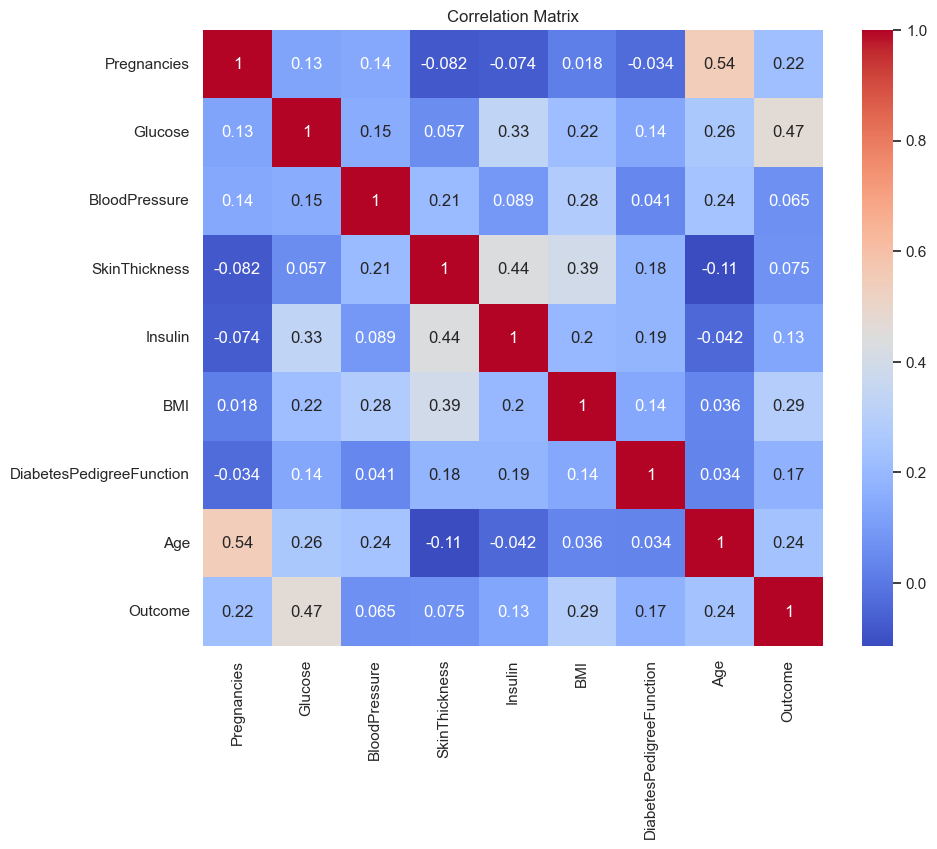

In [25]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

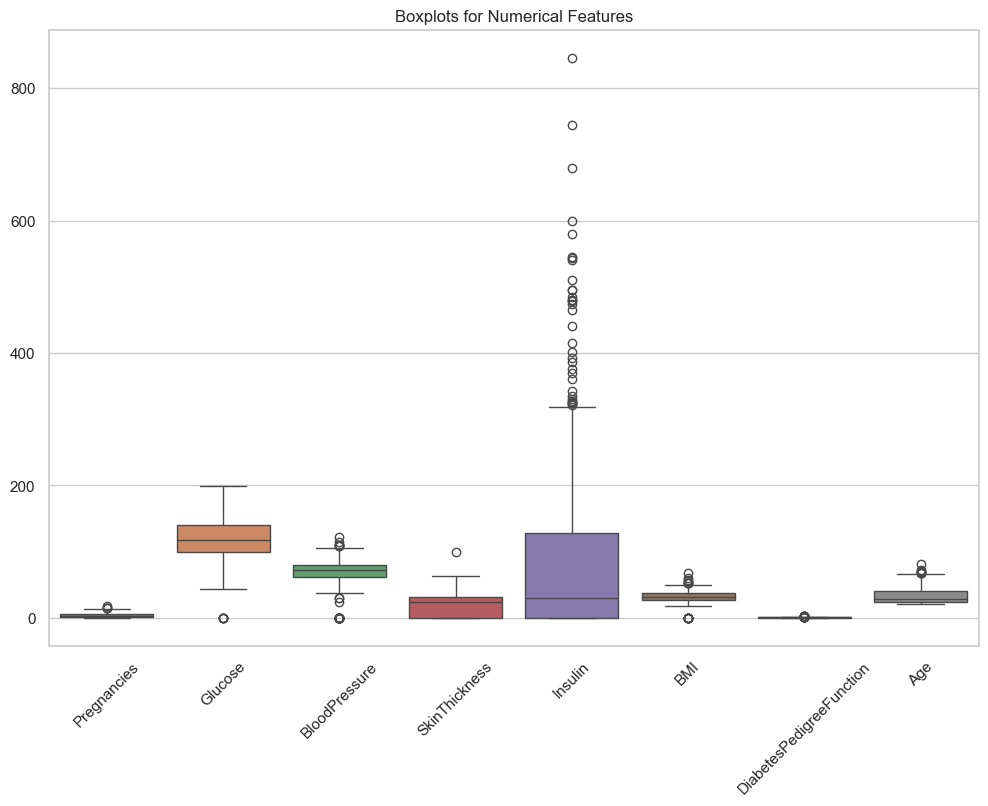

In [26]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=df.drop('Outcome', axis=1))
plt.title('Boxplots for Numerical Features')
plt.xticks(rotation=45)
plt.show()

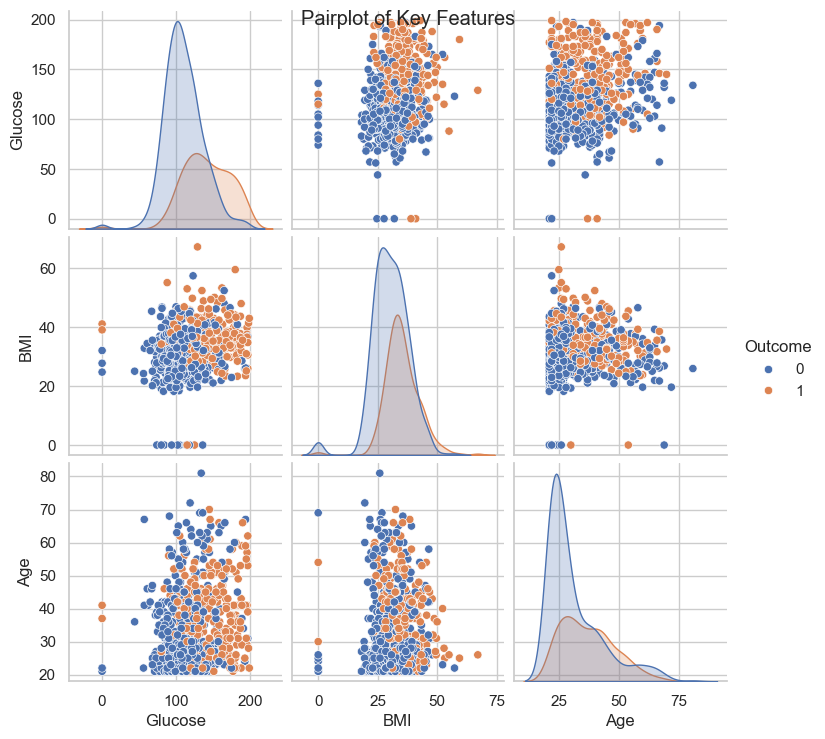

In [27]:
sns.pairplot(df[['Glucose', 'BMI', 'Age', 'Outcome']], hue='Outcome')
plt.suptitle('Pairplot of Key Features')
plt.show()

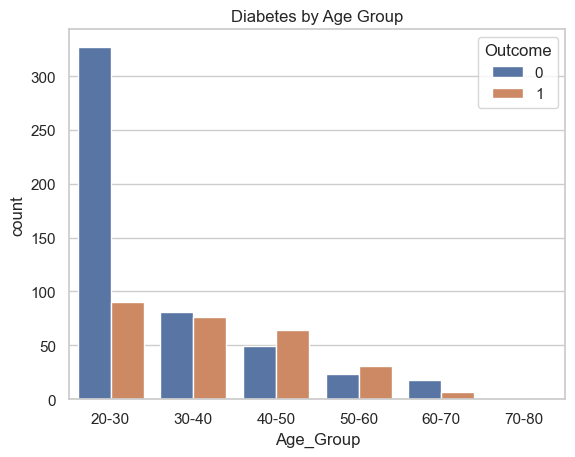

In [28]:
df['Age_Group'] = pd.cut(df['Age'], bins=[20, 30, 40, 50, 60, 70, 80], labels=['20-30', '30-40', '40-50', '50-60', '60-70', '70-80'])
sns.countplot(x='Age_Group', hue='Outcome', data=df)
plt.title('Diabetes by Age Group')
plt.show()

# Data Cleaning and Feature Engineering

In [29]:
cols_with_zeros = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
for col in cols_with_zeros:
    df[col] = df.groupby('Outcome')[col].transform(lambda x: x.replace(0, x.median()))

In [30]:
df['BMI_Category'] = pd.cut(df['BMI'], bins=[0, 18.5, 25, 30, np.inf], labels=['Underweight', 'Normal', 'Overweight', 'Obese'])
df = pd.get_dummies(df, columns=['BMI_Category', 'Age_Group'], drop_first=True)

In [31]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.00000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.677083,72.378906,27.43099,91.783854,32.433919,0.471876,33.240885,0.348958
std,3.369578,30.464161,12.104431,9.32146,108.121136,6.880664,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.00000,0.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,21.00000,39.000000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,27.00000,39.000000,32.050000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.00000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.00000,846.000000,67.100000,2.420000,81.000000,1.000000


# Machine Learning

In [32]:
X = df.drop('Outcome', axis=1)
y = df['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [33]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [34]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=200),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, 'predict_proba') else None
    results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_prob) if y_prob is not None else None
    }
    print(f"{name} Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}")

pd.DataFrame(results).T

Logistic Regression Confusion Matrix:
[[87 13]
 [23 31]]
Random Forest Confusion Matrix:
[[93  7]
 [10 44]]
SVM Confusion Matrix:
[[86 14]
 [21 33]]


,Accuracy,Precision,Recall,F1,ROC AUC
Logistic Regression,0.766234,0.704545,0.574074,0.632653,0.846481
Random Forest,0.889610,0.862745,0.814815,0.838095,0.947870
SVM,0.772727,0.702128,0.611111,0.653465,0.840185


In [35]:
param_grid = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]}
grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5)
grid.fit(X_train_scaled, y_train)
print(f"Best Params: {grid.best_params_}")
best_rf = grid.best_estimator_
y_pred_best = best_rf.predict(X_test_scaled)
print(f"Improved F1: {f1_score(y_test, y_pred_best)}")

Best Params: {'max_depth': None, 'n_estimators': 200}
Improved F1: 0.819047619047619
